In [26]:
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
# sys.path.insert(0, './algorithms')

## Import Wine Dataset

In [27]:
data = np.genfromtxt('data/winequality-white.csv',delimiter=';')[1:]
print(data.shape)

(4898, 12)


In [28]:
X = data[:,:11]
y = data[:,11]
print(X.shape, y.shape)

(4898, 11) (4898,)


In [29]:
def flatten(X):
    '''
    Flatten the data into a single list
    '''
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

def normalize(X):
    '''
    Normalize data
    '''
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    
    return [x - mu for x in X]

## Define Model
I used Logistic Regression in order to classify the wines according to some standard (1-10). Logistic Regression can be used to compute regression as well as classification. It is especially useful when the target is categorical.

NOTE: For multi-class classification, LR uses one-vs-rest mechanism to classify.


In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
X = normalize(X)
model = LogisticRegression(fit_intercept=False, dual= False)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
import random as rand

subsets = []

for i in range(100):        
    subsets.append(rand.sample(list(data), 10))

subsets = np.asarray(subsets)
subsets.shape

(100, 10, 12)

## Given Loss Function

The loss function as detailed in the paper is implemented below.

In [33]:
# Detailed in the paper
def svm_loss(preds, ys, delta=0):
    '''
    Detailed in paper
    '''
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

## Proposed Loss Function and Model

LR is now regularized with Ridge Regression and loss is calculated accordingly

In [34]:
model2 = LogisticRegression(fit_intercept=False, C=2, penalty='l2')
model2.fit(X, y)

def my_loss(preds, ys, delta = 0):
    correct = ys.argmax()
    score_correct = preds[correct]

    loss = 0
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)
    return loss

## Calculate Loss

In [35]:
# Calculate loss
loss = []
reg_loss = []
print("Computing losses...")
for subset in subsets:
    preds = model.predict(subset[:, :11])
    my_preds = model2.predict(subset[:, :11])

    score = np.argmax(preds)
    best_wine = subset[score][11]
    
    loss.append(svm_loss(preds, subset[:,11]))
    reg_loss.append(my_loss(my_preds, subset[:,11]))
print(np.asarray(loss).shape)

Computing losses...
(100,)


## Visualize results

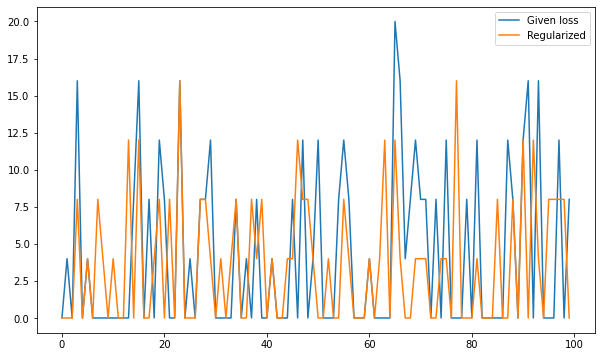

In [36]:
plt.figure(figsize=(10,6))
plt.plot(loss, label="Given loss")
plt.plot(reg_loss, label="Regularized")
plt.legend()
plt.show()

## Experiments

Visualize which c parameter is best using Grid Search and Iterations

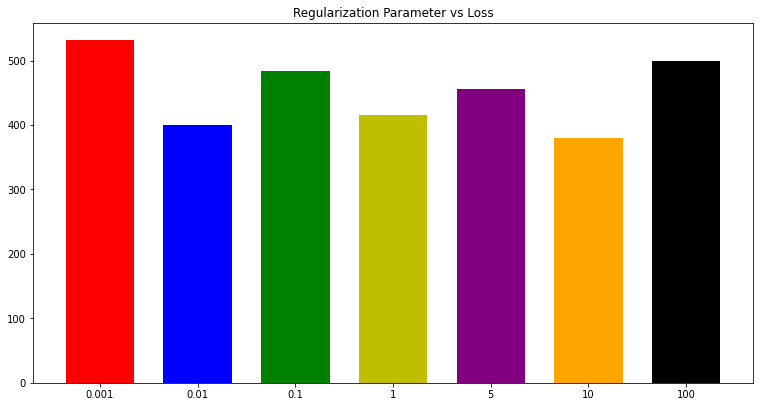

In [71]:
C_param_range = [0.001,0.01,0.1,1,5,10,100]
colors = ['r','b','g','y','purple', 'orange','black']
a = 0

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])

for i in C_param_range:
    lr = LogisticRegression(penalty = 'l2', C = i, fit_intercept=False)
    lr.fit(X,y)
    loss = []
    for subset in subsets:
        preds = lr.predict(subset[:, :11])
        loss.append(svm_loss(preds, subset[:,11]))
    ax.bar(str(i), np.sum(loss), color = colors[a], width = 0.7)
    a+=1

plt.title("Regularization Parameter vs Loss")
plt.show()

### GridSearch

Create a loss function to pass into GridSearch

The loss function takes the sum of all loss calculated for the 100 subsets of given Wine database and chooses the best parameters based on that.

Average loss can also be used to score parameters.

In [83]:
def my_scorer(y_true, y_predicted):
    subsets = []

    for i in range(100):        
        subsets.append(rand.sample(list(zip(y_true, y_predicted)), 10))

    subsets = np.asarray(subsets)
    total = []
    for subset in subsets:
        correct = subset[0].argmax()
        score_correct = subset[1][correct]
        
        loss = 0
        
        for i, pred in enumerate(preds):
            loss += max(0, pred - score_correct)            
                
        total.append(loss)
    return np.sum(total)

In [84]:
from sklearn.metrics import make_scorer
my_func = make_scorer(my_scorer, greater_is_better=False)

In [88]:
from sklearn.model_selection import GridSearchCV
params_dict={'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2']}
clf_lr=GridSearchCV(estimator=LogisticRegression(),param_grid=params_dict,scoring=my_func)
clf_lr.fit(X,y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(my_scorer, greater_is_better=False),
             verbose=0)

In [89]:
clf_lr.best_params_

{'C': 0.01, 'penalty': 'l2'}